# Modelos del lenguaje con RNNs

En esta parte, vamos a entrenar un modelo del lenguaje basado en caracteres con Recurrent Neural Networks. Asimismo, utilizaremos el modelo para generar texto. En particular, alimentaremos nuestro modelo con obras de la literatura clásica en castellano para obtener una red neuronal que sea capaz de "escribir" fragmentos literarios.

Los entrenamientos para obtener un modelo de calidad podrían tomar cierto tiempo (5-10 minutos por epoch), por lo que se aconseja empezar a trabajar pronto. El uso de GPUs no ayuda tanto con LSTMs como con CNNs, por lo que si tenéis máquinas potentes en casa es posible que podáis entrenar más rápido o a la misma velocidad que en Colab. En todo caso, la potencia de Colab es más que suficiente para completar esta actividad con éxito.

<center><img src="https://upload.wikimedia.org/wikipedia/commons/d/d8/El_ingenioso_hidalgo_don_Quijote_de_la_Mancha.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consistirá en un archivo de texto con el contenido íntegro en castellano antiguo de El Ingenioso Hidalgo Don Quijote de la Mancha, disponible de manera libre en la página de [Project Gutenberg](https://www.gutenberg.org). Asimismo, como apartado optativo en este laboratorio se pueden utilizar otras fuentes de texto. Aquí podéis descargar los datos a utilizar de El Quijote y un par de obras adicionales:

[El ingenioso hidalgo Don Quijote de la Mancha (Miguel de Cervantes)](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io)

# 1. Carga y procesado del texto

In [ ]:
import numpy as np
import keras
import random
import re
import matplotlib.pyplot as plt
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from random import sample as sample_rand

from pprint import pprint
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


Primero, vamos a descargar el libro e inspeccionar los datos. El fichero a descargar es una versión en .txt del libro de Don Quijote, a la cual se le han borrado introducciones, licencias y otras secciones para dejarlo con el contenido real de la novela.

In [ ]:
path = keras.utils.get_file(
    fname="don_quijote.txt",
    origin=" https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/textos/Don_Quijote_de_la_Mancha.txt"
)

2151176/2151176 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Se abre y lee el contenido del archivo de texto codificado en UTF-8, convirtiéndolo completamente a minúsculas para reducir la dimensionalidad del vocabulario. Luego, se aplica una limpieza básica con expresiones regulares para eliminar todos los caracteres no deseados, conservando únicamente letras (incluyendo tildes y diéresis del español), signos de puntuación y saltos de línea.

In [ ]:
# Abrir y leer el contenido
with open(path, 'r', encoding='utf-8') as f:
    texto = f.read().lower()

texto = re.sub(r"[^a-záéíóúüñ¡¿ \n\.,:;!\?\"'\(\)\-]", "", texto)

print("Longitud del texto: {}".format(len(texto)))
print(texto[0:300])

Longitud del texto: 2070830
capítulo primero. que trata de la condición y ejercicio del famoso hidalgo
don quijote de la mancha


en un lugar de la mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. una olla de algo más


Podemos comprobar ahora que efectivamente nuestra variable contiene el resultado deseado.

# 2. Procesado de los datos

Una de las grandes ventajas de trabajar con modelos que utilizan caracteres en vez de palabras es que no necesitamos tokenizar el texto (partirlo palabra a palabra). Nuestro modelo funcionará directamente con los caracteres en el texto, incluyendo espacios, saltos de línea, etc.

Antes de hacer nada, necesitamos procesar el texto en entradas y salidas compatibles con nuestro modelo. Como sabemos, un modelo del lenguaje con RNNs acepta una serie de caracteres y predice el siguiente carácter en la secuencia.

* "*El ingenioso don Qui*" -> predicción: **j**
* "*El ingenioso don Quij*" -> predicción: **o**

De modo que la entrada y la salida de nuestro modelo necesita ser algo parecido a este esquema. En este punto, podríamos usar dos formas de preparar los datos para nuestro modelo.

1. **Secuencia a secuencia**. La entrada de nuestro modelo sería una secuencia y la salida sería esa secuencia trasladada un caracter a la derecha, de modo que en cada instante de tiempo la RNN tiene que predecir el carácter siguiente. Por ejemplo:

>* *Input*:   El ingenioso don Quijot
>* *Output*: l ingenioso don Quijote

2. **Secuencia a carácter**. En este variante, pasaríamos una secuencia de caracteres por nuestra RNN y, al llegar al final de la secuencia, predeciríamos el siguiente carácter.

>* *Input*:   El ingenioso don Quijot
>* *Output*: e

Por simplicidad, vamos a utilizar la segunda variante.

De este modo, a partir del texto, hemos de generar nuestro propio training data que consista en secuencias de caracteres con el siguiente carácter a predecir. Para estandarizar las cosas, utilizaremos secuencias de tamaño *SEQ_LENGTH* caracteres (un hiperparámetro que podemos elegir nosotros).



## 2.1. Obtención de los caracteres y mapas de caracteres

Para procesar el texto carácter por carácter, es necesario identificar todos los símbolos distintos presentes en el corpus. A partir de esto, se genera:

1. El número total de caracteres únicos que componen el vocabulario del modelo (num_chars).
2. Un diccionario de codificación (char_to_idx) que asigna a cada carácter un índice único entre 0 y num_chars - 1.
3. Un diccionario de decodificación inverso (idx_to_char) que permite reconstruir el texto a partir de las salidas del modelo.

Estos mapeos permiten transformar el texto en una representación numérica que puede ser utilizada como entrada para el modelo LSTM, y son también esenciales para interpretar sus salidas en la etapa de generación de texto.

In [ ]:
caracteres_unicos = sorted(set(texto))
num_chars = len(caracteres_unicos)
print(num_chars)

char_to_idx = {char: idx for idx, char in enumerate(caracteres_unicos)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
pprint(char_to_idx)
pprint(idx_to_char)


47
{'\n': 0,
 ' ': 1,
 '!': 2,
 '"': 3,
 "'": 4,
 '(': 5,
 ')': 6,
 ',': 7,
 '-': 8,
 '.': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37,
 '¡': 38,
 '¿': 39,
 'á': 40,
 'é': 41,
 'í': 42,
 'ñ': 43,
 'ó': 44,
 'ú': 45,
 'ü': 46}
{0: '\n',
 1: ' ',
 2: '!',
 3: '"',
 4: "'",
 5: '(',
 6: ')',
 7: ',',
 8: '-',
 9: '.',
 10: ':',
 11: ';',
 12: '?',
 13: 'a',
 14: 'b',
 15: 'c',
 16: 'd',
 17: 'e',
 18: 'f',
 19: 'g',
 20: 'h',
 21: 'i',
 22: 'j',
 23: 'l',
 24: 'm',
 25: 'n',
 26: 'o',
 27: 'p',
 28: 'q',
 29: 'r',
 30: 's',
 31: 't',
 32: 'u',
 33: 'v',
 34: 'w',
 35: 'x',
 36: 'y',
 37: 'z',
 38: '¡',
 39: '¿',
 40: 'á',
 41: 'é',
 42: 'í',
 43: 'ñ',
 44: 'ó',
 45: 'ú',
 46: 'ü'}


### 2.2. Obtención de secuencias de entrada y carácter a predecir

Ahora, vamos a obtener las secuencias de entrada en formato texto y los correspondientes caracteres a predecir. Para ello, recorrer el texto completo leído anteriormente, obteniendo una secuencia de SEQ_LENGTH caracteres y el siguiente caracter a predecir. Una vez hecho, desplazarse un carácter a la izquierda y hacer lo mismo para obtener una nueva secuencia y predicción. Guardar las secuencias en una variable ***sequences*** y los caracteres a predecir en una variable ***next_chars***.

Por ejemplo, si el texto fuera "Don Quijote" y SEQ_LENGTH fuese 5, tendríamos

* *sequences* = ["Don Q", "on Qu", "n Qui", " Quij", "Quijo", "uijot"]
* *next_chars* = ['u', 'i', 'j', 'o', 't', 'e']

In [ ]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 30

sequences = []
next_chars = []

for i in range(len(texto) - SEQ_LENGTH):
  sequences.append(texto[i:i + SEQ_LENGTH])
  next_chars.append(texto[i + SEQ_LENGTH])

Indicar el tamaño del training set que acabamos de generar.

In [ ]:
print(len(sequences))

2070800


Como el Quijote es muy largo y tenemos muchas secuencias, podríamos encontrar problemas de memoria. Por ello, vamos a elegir un número máximo de ellas. Si estás corriendo esto localmente y tienes problemas de memoria, puedes reducir el tamaño aún más, pero ten cuidado porque, a menos datos, peor calidad del modelo.

In [ ]:
MAX_SEQUENCES = 2000000       # Para tokenización (Embedding)
MAX_SEQUENCES_ONEHOT = 290000     # Para one-hot (usa menos por RAM)

perm = np.random.permutation(len(sequences))
sequences, next_chars = np.array(sequences), np.array(next_chars)
sequences, next_chars = sequences[perm], next_chars[perm]


### 2.3. Obtención de input X y output y para el modelo

Finalmente, a partir de los datos de entrenamiento que hemos generado vamos a crear los arrays de datos X e y que pasaremos a nuestro modelo.

#### Dataset Embedding

Se construyen las matrices de entrada (X) y salida (y) que alimentarán al modelo LSTM para la tarea de generación de texto carácter a carácter. Para limitar la cantidad de datos procesados, se seleccionan las primeras MAX_SEQUENCES secuencias del corpus.

Cada secuencia de entrada se transforma en una matriz de enteros mediante un diccionario de mapeo char_to_idx, mientras que la salida corresponde al carácter siguiente a cada secuencia, también representado como entero. Esta representación discreta permite posteriormente el uso de una capa de embedding, que aprenderá relaciones semánticas entre caracteres durante el entrenamiento, a diferencia del enfoque tradicional basado en codificación one-hot.

In [ ]:
sequences_embed = sequences[:MAX_SEQUENCES]
next_chars_embed = next_chars[:MAX_SEQUENCES]

X = np.zeros((MAX_SEQUENCES, SEQ_LENGTH), dtype=np.int32)   # Mantiene el nombre original
y = np.zeros((MAX_SEQUENCES,), dtype=np.int32)

for i, seq in enumerate(sequences_embed):
    for t, char in enumerate(seq):
        X[i, t] = char_to_idx[char]
    y[i] = char_to_idx[next_chars_embed[i]]

print(f"[EMBED] X shape: {X.shape}")
print(f"[EMBED] y shape: {y.shape}")


[EMBED] X shape: (2000000, 30)
[EMBED] y shape: (2000000,)


#### Dataset One hot

Se construye las matrices de entrada y salida para un modelo LSTM que utiliza codificación one-hot, sin capa de embedding. Se limita la cantidad de datos mediante el parámetro MAX_SEQUENCES_ONEHOT.

Cada carácter en las secuencias se representa como un vector binario de dimensión num_chars, donde solo una posición es 1 (correspondiente al índice del carácter) y el resto son ceros.

Este enfoque, aunque menos eficiente en memoria que el uso de embeddings, permite que el modelo procese directamente la distribución completa del vocabulario en cada paso de la secuencia, lo cual puede ser útil en contextos donde se requiere un control más explícito sobre la representación del texto.

In [ ]:
sequences_1hot = sequences[:MAX_SEQUENCES_ONEHOT]
next_chars_1hot = next_chars[:MAX_SEQUENCES_ONEHOT]

X_1hot = np.zeros((MAX_SEQUENCES_ONEHOT, SEQ_LENGTH, num_chars), dtype=np.bool_)
y_1hot = np.zeros((MAX_SEQUENCES_ONEHOT, num_chars), dtype=np.bool_)

for i, seq in enumerate(sequences_1hot):
    for t, char in enumerate(seq):
        X_1hot[i, t, char_to_idx[char]] = 1
    y_1hot[i, char_to_idx[next_chars_1hot[i]]] = 1

print(f"[ONE-HOT] X_1hot shape: {X_1hot.shape}")
print(f"[ONE-HOT] y_1hot shape: {y_1hot.shape}")

[ONE-HOT] X_1hot shape: (290000, 30, 47)
[ONE-HOT] y_1hot shape: (290000, 47)


# 3. Definición del los modelos y entrenamientos

En esta sección se presenta la arquitectura de los modelos diseñados para la generación de texto a partir del corpus procesado. Se describen las configuraciones específicas, incluyendo el tratamiento de los datos de entrada (carácter a carácter y palabra por palabra), las capas utilizadas y los hiperparámetros seleccionados. Además, se detallan los procedimientos de entrenamiento aplicados, así como las estrategias para la evaluación y generación de texto, con el fin de analizar el desempeño y las capacidades de cada modelo.

## Consideraciones previas al entrenamiento

- En este trabajo se utilizó exclusivamente la función de **pérdida (loss)** como métrica principal para evaluar el desempeño de los modelos debido a la naturaleza del problema de generación de texto secuencial. La pérdida, calculada mediante sparse categorical crossentropy o categorical crossentropy en el caso del dataset con one-hot, refleja directamente la capacidad del modelo para ajustar la distribución de probabilidad sobre las siguientes unidades (caracteres o palabras) en la secuencia, lo cual es fundamental para la calidad del texto generado. Otras métricas como **accuracy** o **F1-score**, aunque comúnmente usadas en tareas de clasificación, resultan menos informativas en este contexto porque no capturan completamente la coherencia y fluidez de secuencias generadas de forma autoregresiva.

- **Definicion tipo de red**: Se utilizaron redes LSTM en lugar de RNN simples porque el texto de Don Quijote presenta secuencias largas y complejas, con dependencias que pueden abarcar muchas palabras. Las RNN tienen dificultades para capturar estas relaciones debido al problema del desvanecimiento del gradiente, mientras que las LSTM, gracias a sus mecanismos de memoria, pueden retener información relevante durante más tiempo. Esto permite una mejor comprensión del contexto y una generación de texto más coherente y fluida, lo cual es clave en el procesamiento de obras literarias extensas.

## Funciones de generación de texto

In [ ]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.

    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]

      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados.

        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')

    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature

    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)

    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    return np.argmax(samples)

TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 300

def generate_text(seed_text, model, length, temperature=1):
    generated = seed_text
    sentence = seed_text

    for _ in range(length):
        x_pred = np.zeros((1, SEQ_LENGTH, num_chars))
        for t, char in enumerate(sentence):
            if char in char_to_idx:
                x_pred[0, t, char_to_idx[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = idx_to_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

    return generated

def generate_text_emb(seed_text, model, length, temperature=1):
    generated = seed_text
    sentence = seed_text

    for _ in range(length):
        # Convertir la frase actual en una secuencia de índices
        x_pred = np.zeros((1, SEQ_LENGTH), dtype=np.int32)
        for t, char in enumerate(sentence):
            if char in char_to_idx:
                x_pred[0, t] = char_to_idx[char]
            else:
                x_pred[0, t] = 0

        # Predecir el siguiente carácter
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = idx_to_char[next_index]

        # Añadir carácter generado al texto
        generated += next_char

        # Actualizar ventana de entrada
        sentence = sentence[1:] + next_char

    return generated

def generate_text_token(seed_text, model, tokenizer, max_sequence_len, length, temperature=1):
    generated = seed_text

    for _ in range(length):
        # Convertir texto a secuencia de índices
        token_list = tokenizer.texts_to_sequences([generated])[0]

        # Tomar solo los últimos max_sequence_len-1 tokens para input
        token_list = token_list[-(max_sequence_len-1):]

        # Padding para que tenga la longitud correcta
        token_list_padded = pad_sequences(
            [token_list], maxlen=max_sequence_len-1, padding='pre'
        )

        # Predecir siguiente token (probabilidades)
        preds = model.predict(token_list_padded, verbose=0)[0]

        # Usar sampling con temperatura para elegir índice del siguiente token
        next_index = sample(preds, temperature)

        # Obtener la palabra correspondiente al índice
        for word, index in tokenizer.word_index.items():
            if index == next_index:
                next_word = word
                break
        else:
            next_word = ''  # fallback en caso no encontrado

        # Añadir palabra generada
        generated += ' ' + next_word

    return generated

1. **sample**: Ajusta la distribución de probabilidad predicha por el modelo usando un parámetro de temperatura para controlar la diversidad del muestreo, permitiendo elegir resultados más conservadores o más creativos.
2. **generate_text**: genera texto carácter por carácter usando una codificación one-hot, prediciendo y muestreando el siguiente carácter iterativamente según la temperatura.
3. **generate_text_emb**: genera texto carácter por carácter usando codificación por índices (embedding), preparando la entrada como secuencia de enteros y muestreando el siguiente carácter.
4. **generate_text_token**: genera texto palabra por palabra a partir de un tokenizer, convirtiendo el texto generado en secuencias tokenizadas con padding para predecir y muestrear la siguiente palabra iterativamente.

## Callbacks

Se utilizo el callback EarlyStopping, que detiene el entrenamiento si la pérdida no mejora durante 3 épocas consecutivas, evitando sobreentrenamiento.

In [ ]:
early_stopping = EarlyStopping(
    monitor='loss',     # Métrica a observar
    patience=3,             # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaura los pesos con mejor val_loss
)

## LSTM con One-hot

### Arquitectura


El modelo "modelo_LSTM_onehot" está definido como una red secuencial con dos capas principales:

**Capa LSTM**: Esta capa contiene 128 unidades recurrentes y se encarga de procesar secuencias de entrada ya codificadas en formato one-hot. Su objetivo es capturar dependencias temporales en el texto, permitiendo al modelo aprender patrones en la secuencia de caracteres.

**Capa Densa (Salida)**: Utiliza una activación softmax para generar una distribución de probabilidad sobre todos los caracteres del vocabulario, permitiendo predecir el carácter siguiente en la secuencia.

El modelo se compila con el optimizador Adam y la función de pérdida categorical_crossentropy.

In [ ]:
model_onehot = Sequential(name="modelo_LSTM_onehot")

# Entrada ya está one-hot encoded: (SEQ_LENGTH, vocab_size)
model_onehot.add(LSTM(128, input_shape=(SEQ_LENGTH, num_chars), name="LSTM"))

# Capa de salida
model_onehot.add(Dense(num_chars, activation='softmax', name="Salida"))

# Compilar modelo
model_onehot.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Mostrar resumen
model_onehot.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "modelo_LSTM_onehot"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 128)            │        90,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Salida (Dense)                  │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,175 (375.68 KB)

 Trainable params: 96,175 (375.68 KB)

 Non-trainable params: 0 (0.00 B)

### Hiperparámetros

En el modelo "modelo_LSTM_onehot", los hiperparámetros seleccionados inciden directamente en su rendimiento. En particular:

- Unidades LSTM: 128 → permiten capturar dependencias temporales complejas sin sobrecargar el modelo.

- Función de pérdida: categorical_crossentropy → adecuada para clasificación multiclase sobre caracteres codificados en one-hot.

- Optimizador: Adam → acelera la convergencia y mejora la estabilidad del entrenamiento.

- Batch size: 128 → tamaño moderado que facilita un buen balance entre eficiencia computacional y estabilidad en el cálculo del gradiente, acelerando el entrenamiento sin sacrificar precisión ni exigir excesivos recursos de memoria.

- Épocas: hasta 100 → permiten suficiente tiempo para la convergencia, con posibilidad de detenerse antes mediante EarlyStopping para evitar sobreajuste.

### Entrenamiento

A continuación, se procede al entrenamiento del modelo utilizando los datos codificados en formato one-hot. Se entrena durante un máximo de 100 épocas con un batch size de 128, incorporando el callback EarlyStopping para evitar sobreentrenamiento. Además, se registra el tiempo total de entrenamiento para evaluar el rendimiento computacional del proceso.

In [ ]:
start_time = time.time()

history_onehot = model_onehot.fit(
    X_1hot, y_1hot,
    epochs=100,
    batch_size=128,
    callbacks=[early_stopping]
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo total de entrenamiento (one-hot): {elapsed_time:.2f} segundos")

Epoch 1/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.2607 - loss: 2.6001
Epoch 2/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3693 - loss: 2.0584
Epoch 3/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3995 - loss: 1.9454
Epoch 4/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4217 - loss: 1.8690
Epoch 5/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4409 - loss: 1.8027
Epoch 6/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4546 - loss: 1.7535
Epoch 7/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4701 - loss: 1.7102
Epoch 8/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4814 - loss: 1.6736
Epoch 9/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4919 - loss: 1.6391
Epoch 10/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.4999 - loss: 1.6124
Epoch 11/100
2266/2266 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.5074 - loss: 1.5885
Epoch 12

El modelo se entrenó correctamente durante 100 épocas. Aunque se utilizó el callback EarlyStopping para detener el entrenamiento en caso de no observar mejoras, en esta ocasión el criterio de detención temprana no se activó, por lo que el proceso completó el máximo de 100 épocas definidas previamente.

### Gráficos

A continuación, se presenta el gráfico de la pérdida a lo largo de las épocas del modelo.

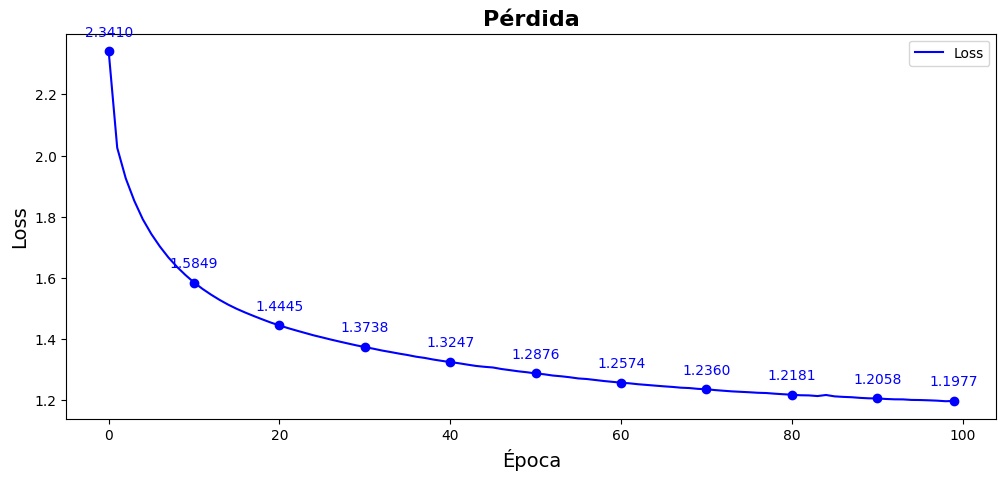

In [ ]:
# Datos
loss = history_onehot.history['loss']
epochs = range(len(loss))

# Crear figura
fig, ax = plt.subplots(figsize=(12, 5))

# Curva de pérdida
ax.plot(epochs, loss, label="Loss", color='blue')

# Marcar cada 10 épocas y el último punto
for i in range(0, len(loss), 10):
    ax.scatter(i, loss[i], color='blue')
    ax.annotate(f"{loss[i]:.4f}",
                xy=(i, loss[i]),
                xytext=(i, loss[i] + 0.05),
                ha='center',
                fontsize=10,
                color='blue')

# Marcar el punto final (por si no es múltiplo de 10)
last_epoch = len(loss) - 1
if last_epoch % 10 != 0:
    ax.scatter(last_epoch, loss[-1], color='blue')
    ax.annotate(f"{loss[-1]:.4f}",
                xy=(last_epoch, loss[-1]),
                xytext=(last_epoch, loss[-1] + 0.05),
                ha='center',
                fontsize=10,
                color='blue')

# Estilo del gráfico
ax.set_title('Pérdida', fontsize=16, fontweight="bold")
ax.set_xlabel('Época', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend()

plt.show()

El gráfico muestra una caída pronunciada en la pérdida durante las primeras 20 épocas, indicando un aprendizaje rápido en las etapas iniciales. A partir de ahí, la disminución se vuelve más lenta y progresiva, lo que sugiere que el modelo continúa mejorando, pero de forma más estable, hasta completar las 100 épocas.

### Generación del modelo

Guardado del modelo para su uso posterior.

In [ ]:
model_onehot.save("model_onehot.keras")

Una vez finalizado el entrenamiento, se procede a generar texto a partir del modelo entrenado. Para observar cómo varía la creatividad y diversidad en las predicciones, se utiliza la técnica de muestreo con diferentes temperaturas. En este caso, se evalúan tres valores: 0.2, 0.5 y 0.8, partiendo desde el mismo texto semilla. A menor temperatura, las predicciones tienden a ser más conservadoras y repetitivas, mientras que temperaturas más altas generan resultados más variados y menos predecibles.

In [ ]:
temperaturas = [0.2, 0.5, 0.8]
seed_text = "o le cautivaron y rindieron el"
longitud_generada = 300

# Generar texto con el modelo entrenado
for temp in temperaturas:
    print(f"\n--- Generación con temperatura: {temp} ---")
    texto_generado_one = generate_text(seed_text, model_onehot, length=longitud_generada, temperature=temp)
    print("Texto generado:\n", texto_generado_one)


--- Generación con temperatura: 0.2 ---
Texto generado:
 o le cautivaron y rindieron el labrador que era con el mesmo de la persona de mi confirmó a la cabeza de la caballería andar el cura de la verdad que es el cura de sus manos que se le de la mano a la cabeza que en todos los que se enamorades el de la alanza de la mano en la mano, con el mundo nuevo que el que con el mando no se 

--- Generación con temperatura: 0.5 ---
Texto generado:
 o le cautivaron y rindieron el ladría a sentias a don quijote y a su amigo de las palabras de la cabeza de la deshora en su padre de la mano que era don quijote, que estaba hallarle el propuradera y estaba en el mundad''. y a tu esemples que los señores, que no lo que todos les sancho: que la hermosa me había mayor caballero, y 

--- Generación con temperatura: 0.8 ---
Texto generado:
 o le cautivaron y rindieron el anto, y procurió, que fuemen abrinear en confesa un andantido posible la imagino y las ordenado.

-no hay parecer mucha vez se puedo 

Se observa que el modelo es capaz de generar texto, y que al aumentar la temperatura, especialmente a 0.8, produce textos más variados y con un uso más frecuente de caracteres como comas, guiones y saltos de línea. Sin embargo, este incremento en la temperatura también provoca que la coherencia del texto disminuya notablemente, generando frases más desordenadas y difíciles de comprender. En temperaturas más bajas, como 0.2, el texto es más estructurado y con mejor sintaxis, aunque menos diverso y con repeticiones. A temperatura intermedia, 0.5, se alcanza un equilibrio entre variedad y coherencia, aunque las ideas aún pueden resultar inconexas. Esto muestra cómo la temperatura influye en el balance entre creatividad y coherencia en la generación de texto del modelo.

## LSTM con Embedding

### Arquitectura

El modelo "modelo_LSTM_embedding" es una red secuencial compuesta por tres capas principales:

**Capa Embedding**: Transforma los índices enteros de los caracteres en vectores densos de dimensión 64. Esta capa permite que el modelo aprenda representaciones distribuidas de los caracteres, capturando similitudes y relaciones semánticas entre ellos durante el entrenamiento.

**Capa LSTM**: Con 128 unidades, esta capa procesa las secuencias de vectores generadas por el embedding, modelando dependencias contextuales y temporales entre los caracteres para predecir el siguiente en la secuencia.

**Capa Densa (Salida)**: Proyecta la salida de la LSTM a una distribución de probabilidad sobre todos los caracteres posibles mediante activación softmax.

El modelo se compila usando el optimizador Adam y la función de pérdida sparse_categorical_crossentropy.

In [ ]:
model_emb = Sequential(name="modelo_LSTM_embedding")

# Capa de embedding
model_emb.add(Embedding(input_dim=num_chars, output_dim=64,
                        input_shape=(SEQ_LENGTH, ), name="Embedding"))

# Capa LSTM
model_emb.add(LSTM(128, name="LSTM"))

# Capa de salida
model_emb.add(Dense(num_chars, activation='softmax', name="Salida"))

# Compilar modelo
model_emb.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Mostrar resumen
model_emb.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "modelo_LSTM_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)           │ (None, 30, 64)         │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Salida (Dense)                  │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,887 (421.43 KB)

 Trainable params: 107,887 (421.43 KB)

 Non-trainable params: 0 (0.00 B)

### Hiperparámetros

En el modelo "modelo_LSTM_embedding", los hiperparámetros seleccionados afectan directamente su desempeño y eficiencia:

- Capa Embedding (output_dim=64) → transforma los índices de caracteres en vectores densos de dimensión 64, facilitando que el modelo capture relaciones semánticas y contextuales de manera más eficiente que con codificación one-hot.

- Unidades LSTM: 128 → permiten modelar dependencias temporales complejas en las secuencias de caracteres, manteniendo un equilibrio entre capacidad y eficiencia computacional.

- Función de pérdida: sparse_categorical_crossentropy → apropiada para clasificación multiclase cuando las etiquetas están codificadas como enteros, optimizando el cálculo en problemas de texto.

- Optimizador: Adam → mejora la velocidad y estabilidad del entrenamiento al ajustar dinámicamente las tasas de aprendizaje.

- Batch size: 128 → tamaño que equilibra un entrenamiento eficiente y estable, reduciendo el uso de memoria sin comprometer la calidad del aprendizaje.

- Épocas: hasta 100 → brindan oportunidad suficiente para la convergencia, mientras que el uso de EarlyStopping permite evitar el sobreentrenamiento deteniendo el proceso cuando no hay mejoras significativas.

### Entrenamiento

A continuación, se entrena el modelo con codificación embedding, utilizando un batch size de 128 y un máximo de 100 épocas. Se aplica el callback EarlyStopping para evitar sobreentrenamiento y se mide el tiempo total de entrenamiento como referencia de rendimiento.

In [ ]:
start_time = time.time()

history_emb = model_emb.fit(X ,y , epochs=100, batch_size=128, callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos")

Epoch 1/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.4039 - loss: 1.9645
Epoch 2/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5298 - loss: 1.5129
Epoch 3/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5501 - loss: 1.4340
Epoch 4/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5603 - loss: 1.3974
Epoch 5/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5674 - loss: 1.3723
Epoch 6/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5728 - loss: 1.3538
Epoch 7/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.5756 - loss: 1.3437
Epoch 8/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5788 - loss: 1.3339
Epoch 9/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5817 - loss: 1.3234
Epoch 10/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5831 - loss: 1.3164
Epoch 11/100
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5851 -

El modelo se entrenó durante 59 épocas. Aunque se definieron 100 épocas, el entrenamiento se detuvo antes gracias al uso de EarlyStopping, que identificó que no había mejoras significativas en la pérdida. El tiempo total de entrenamiento fue de aproximadamente 4063.57 segundos.

### Gráficos


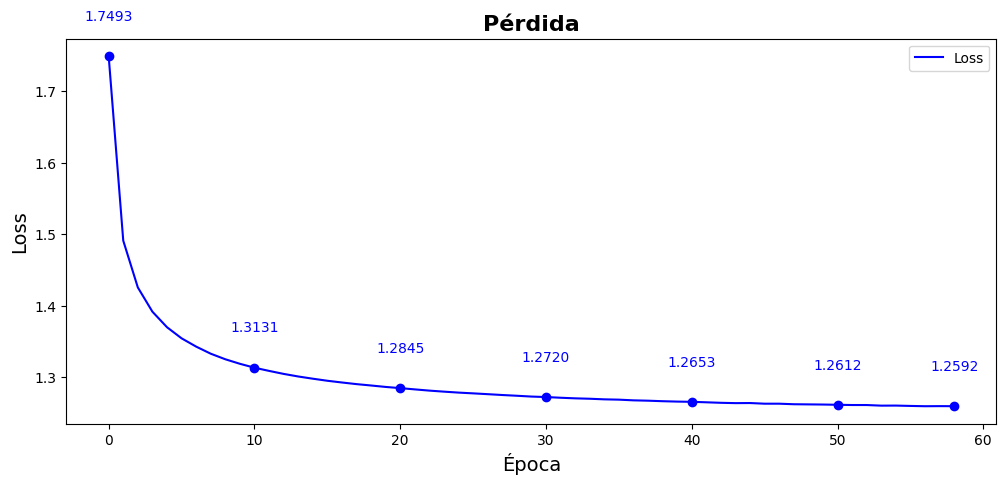

In [ ]:
# Datos
loss = history_emb.history['loss']
epochs = range(len(loss))

# Crear figura
fig, ax = plt.subplots(figsize=(12, 5))

# Curva de pérdida
ax.plot(epochs, loss, label="Loss", color='blue')

# Marcar cada 10 épocas y el último punto
for i in range(0, len(loss), 10):
    ax.scatter(i, loss[i], color='blue')
    ax.annotate(f"{loss[i]:.4f}",
                xy=(i, loss[i]),
                xytext=(i, loss[i] + 0.05),
                ha='center',
                fontsize=10,
                color='blue')

# Marcar el punto final (por si no es múltiplo de 10)
last_epoch = len(loss) - 1
if last_epoch % 10 != 0:
    ax.scatter(last_epoch, loss[-1], color='blue')
    ax.annotate(f"{loss[-1]:.4f}",
                xy=(last_epoch, loss[-1]),
                xytext=(last_epoch, loss[-1] + 0.05),
                ha='center',
                fontsize=10,
                color='blue')

# Estilo del gráfico
ax.set_title('Pérdida', fontsize=16, fontweight="bold")
ax.set_xlabel('Época', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend()

plt.show()

El gráfico muestra una curva pronunciada de disminución de la pérdida y aumento de la precisión durante las primeras 10 épocas. Luego, la mejora se vuelve más gradual y progresiva hasta la época 59, momento en que EarlyStopping detuvo el entrenamiento por falta de mejoras significativas.

### Generación del modelo

Guardado del modelo para su uso posterior.

In [ ]:
model_emb.save("model_emb.keras")

Una vez finalizado el entrenamiento, se procede a generar texto a partir del modelo entrenado. Para observar cómo varía la creatividad y diversidad en las predicciones, se utiliza la técnica de muestreo con diferentes temperaturas. En este caso, se evalúan tres valores: 0.2, 0.5 y 0.8, partiendo desde el mismo texto semilla. A menor temperatura, las predicciones tienden a ser más conservadoras y repetitivas, mientras que temperaturas más altas generan resultados más variados y menos predecibles. Esta mejora en la generación respecto al modelo one-hot puede deberse a que aquí se utilizó casi todo el corpus para el entrenamiento, mientras que en el modelo one-hot se usó una muestra reducida por limitaciones de RAM.

In [ ]:
seed_text = "o le cautivaron y rindieron el"

# Generar texto con el modelo entrenado
for temp in temperaturas:
    print(f"\n--- Generación con temperatura: {temp} ---")
    texto_generado_emb = generate_text_emb(seed_text, model_emb, length=longitud_generada, temperature=temp)
    print("Texto generado:\n", texto_generado_emb)


--- Generación con temperatura: 0.2 ---
Texto generado:
 o le cautivaron y rindieron el camino que en la mano a la cabeza, y a la casa de la cabeza de la cabeza de la mano a los dos soldados y de la mano a la mano a la cabeza y la cabeza a la cabeza de la cabeza de la mano a la cabeza de la cabeza y de la mano a la cabeza, y a la cabeza, y en el mundo que allí a la cabeza, y la vida q

--- Generación con temperatura: 0.5 ---
Texto generado:
 o le cautivaron y rindieron el camino de la mancha, y dijo:

-ahora se viese la mañana de la cortesía y no lo había en cuanto dijese la calitada en la duquesa con el casa, y aun me
hallase para descubrieron las armas y de tu casa no diga que por no ser en esto, dijo:

-¿qué viniera, sin visto en el caballero que no se deben deci

--- Generación con temperatura: 0.8 ---
Texto generado:
 o le cautivaron y rindieron el bachiller nuncanto,
porque no sé que no lo hará mi concertada; porque, sobre todo desvalido atarde dira donde está vive con la arrima

El modelo con embedding genera textos con cierta coherencia a temperatura baja (0.2), aunque repetitivos y limitados en contenido. A temperatura 0.5, el texto es más variado, mostrando fragmentos más reconocibles y coherentes, siendo este el nivel con mayor claridad. A temperatura 0.8, el texto es más libre y diverso en signos y vocabulario, pero pierde coherencia, resultando en frases más fragmentadas y aleatorias.

## LSTM palabra por palabra

El siguiente modelo está diseñado para aprender la secuencia y contexto en textos a nivel de palabra, utilizando una arquitectura basada en capas LSTM que permite capturar dependencias a largo plazo entre las palabras. La entrada al modelo corresponde a secuencias de palabras tokenizadas y padded, donde cada palabra se representa mediante un entero que luego es transformado en vectores densos mediante una capa de embedding.

### Funciones de utilidad

In [ ]:
def get_sequence_of_tokens(corpus, tokenizer):
    tokenizer.fit_on_texts(corpus)
    total_words = min(5000, len(tokenizer.word_index) + 1)

    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        if len(token_list) < 2:
            continue
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

def generate_padded_sequences(input_sequences,total_words):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    #label = keras.utils.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

1. **get_sequence_of_tokens**: tokeniza el corpus y genera secuencias de tipo n-grama crecientes, limitando el vocabulario a 5000 palabras para evitar alta dimensionalidad.

2. **generate_padded_sequences**: aplica padding al inicio de las secuencias para igualar su longitud y separa las entradas (predictors) de las etiquetas (label), dejando los datos listos para entrenar el modelo LSTM.

### Secuencias tokenizadas

Se procede a crear un Tokenizer limitado a un vocabulario máximo de 5000 palabras para controlar la complejidad del modelo. Luego, el texto completo se segmenta en párrafos utilizando una expresión regular que detecta saltos de línea dobles, descartando entradas vacías para asegurar datos limpios. Tambien limita la cantidad de secuencias a 100000. Para evitar que los recursos de la maquina otorgada por Colab se acaben.

In [ ]:
tokenizer = Tokenizer(num_words=5000)

# Separa el texto por párrafos
corpus = [p.strip() for p in re.split(r'\n\s*\n+', texto) if p.strip()]

inp_sequences, total_words = get_sequence_of_tokens(corpus, tokenizer)

# Reduce la cantidad de secuencias
inp_sequences = sample_rand(inp_sequences, k=min(100000, len(inp_sequences)))

print(f"Total secuencias: {len(inp_sequences)}")
print(f"Vocabulario usado (total_words): {total_words}")

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences, total_words)

print(f"Total de predictores (predictors): {predictors}")

Total secuencias: 100000
Vocabulario usado (total_words): 5000
Total de predictores (predictors): [[   0    0    0 ...  335    3   98]
 [   0    0    0 ...   25    3 1218]
 [   0    0    0 ...    1 1243 1790]
 ...
 [   0    0    0 ...   82   36    2]
 [   0    0    0 ...  545 1802   78]
 [   0    0    0 ...  558    2    8]]


Se puede observar que se han generado un total de 100,000 secuencias y que el vocabulario efectivo tokenizado está limitado a 5,000 palabras, como se estableció para controlar la complejidad del modelo.

### Arquitectura

El modelo "model_token" está definido como una red secuencial compuesta por tres capas principales:

**Capa Embedding**: Esta capa inicial transforma los índices enteros de las palabras en vectores densos de dimensión 128. Permite que el modelo aprenda representaciones semánticas distribuidas para cada palabra, facilitando la captura de relaciones contextuales durante el entrenamiento. La dimensión de entrada está definida por la longitud de secuencia menos uno (max_sequence_len - 1).

**Capa LSTM**: Con 128 unidades recurrentes, esta capa procesa las secuencias temporales, modelando dependencias a largo plazo entre palabras. La LSTM es especialmente adecuada para texto por su capacidad para retener información contextual relevante a través de secuencias extensas.

**Capa Dropout**: Con una tasa de 0.1, ayuda a prevenir el sobreajuste durante el entrenamiento, introduciendo aleatoriedad en las conexiones de la red.

**Capa Densa (Salida)**: Proyecta la salida de la LSTM a un vector de probabilidades sobre el vocabulario completo, usando la función de activación softmax, para predecir la siguiente palabra en la secuencia.

In [ ]:
model_token = Sequential(name="token")

# Capa de Embedding
input_len = max_sequence_len - 1
model_token.add(Embedding(total_words, 128, input_shape=(SEQ_LENGTH, ), name="Embedding"))

# Capa LSTM + Dropout
model_token.add(LSTM(128, name="CapaLSTM"))
model_token.add(Dropout(0.1, name="Dropout"))

# Capa de salida
model_token.add(Dense(total_words, activation='softmax', name="Densa"))

# Compilación
model_token.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])

# Mostrar resumen
model_token.summary()

Model: "token"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding (Embedding)           │ (None, 30, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CapaLSTM (LSTM)                 │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Densa (Dense)                   │ (None, 5000)           │       645,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,416,584 (5.40 MB)

 Trainable params: 1,416,584 (5.40 MB)

 Non-trainable params: 0 (0.00 B)

### Hiperparámetros

En el modelo "token", los hiperparámetros ajustados influyen directamente en su rendimiento y eficiencia:

- Capa Embedding (output_dim=128) → convierte los índices de palabras en vectores densos de dimensión 128, permitiendo capturar relaciones semánticas más ricas y contextuales entre palabras del vocabulario.

- Unidades LSTM: 128 → procesan secuencias para modelar dependencias temporales largas, balanceando capacidad de aprendizaje y complejidad computacional.

- Capa Dropout (0.1) → introduce regularización para reducir el sobreajuste, mejorando la generalización del modelo durante el entrenamiento.

- Función de pérdida (sparse_categorical_crossentropy) → adecuada para problemas de clasificación multiclase con etiquetas enteras, optimizando la eficiencia del cálculo.

- Optimizador (Adam) → acelera la convergencia y estabiliza el proceso de entrenamiento mediante ajustes adaptativos en la tasa de aprendizaje.

- Batch size: 128 → tamaño de lote que equilibra la estabilidad y eficiencia computacional, ayudando a un entrenamiento rápido sin consumir excesiva memoria.

- Épocas: hasta 100 → permiten un entrenamiento suficientemente largo para converger, con EarlyStopping para detenerlo si no se observan mejoras, evitando así el sobreajuste.



### Entrenamiento

Se decidió entrenar el modelo durante un máximo de 100 épocas, utilizando el callback early_stopping previamente definido, que detiene el entrenamiento si la métrica de pérdida (loss) no mejora durante 3 épocas consecutivas.

In [ ]:
start_time = time.time()

history_token = model_token.fit(predictors, label, batch_size=128, epochs=100, callbacks=[early_stopping])

end_time = time.time()

elapsed_time_token = end_time - start_time
print(f"Tiempo total de entrenamiento: {elapsed_time_token:.2f} segundos")

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.0605 - loss: 6.4454
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.0885 - loss: 5.7209
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1190 - loss: 5.4942
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1313 - loss: 5.3194
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1357 - loss: 5.1709
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.1444 - loss: 5.0414
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1486 - loss: 4.9582
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.1558 - loss: 4.8557
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.1572 - loss: 4.7576
Epoch 10/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1622 - loss: 4.6736
Epoch 11/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.1720 - loss: 4.5802
Epoch 12/100
782/78

Se observa que el entrenamiento tuvo una duración aproximada de una hora y no fue interrumpido por el mecanismo de early stopping, lo que sugiere que el modelo podría haber seguido mejorando con más tiempo de entrenamiento. Sin embargo, por razones de tiempo y disponibilidad de recursos computacionales, se opta por mantener el modelo en la época 100.

### Gráficos

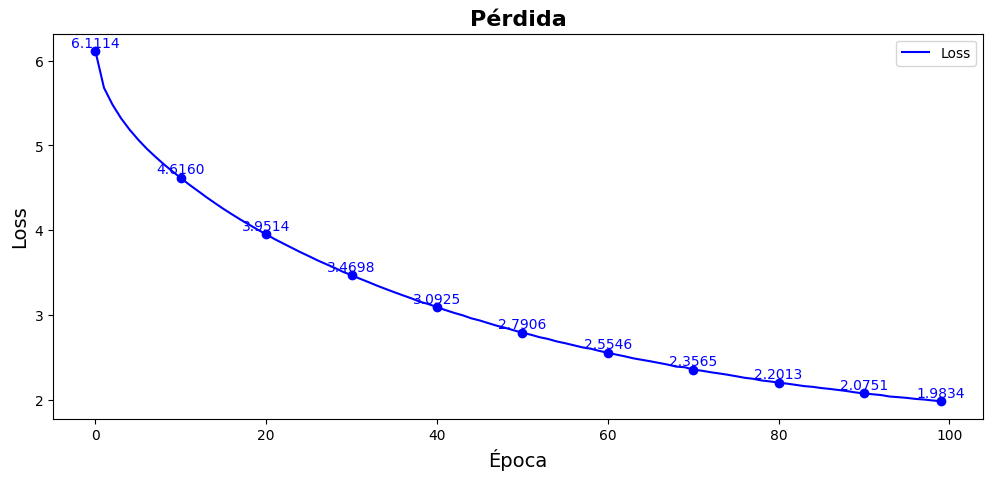

In [ ]:
# Datos
loss = history_token.history['loss']
epochs = range(len(loss))

# Crear figura
fig, ax = plt.subplots(figsize=(12, 5))

# Curva de pérdida
ax.plot(epochs, loss, label="Loss", color='blue')

# Marcar cada 10 épocas y el último punto
for i in range(0, len(loss), 10):
    ax.scatter(i, loss[i], color='blue')
    ax.annotate(f"{loss[i]:.4f}",
                xy=(i, loss[i]),
                xytext=(i, loss[i] + 0.05),
                ha='center',
                fontsize=10,
                color='blue')

# Marcar el punto final (por si no es múltiplo de 10)
last_epoch = len(loss) - 1
if last_epoch % 10 != 0:
    ax.scatter(last_epoch, loss[-1], color='blue')
    ax.annotate(f"{loss[-1]:.4f}",
                xy=(last_epoch, loss[-1]),
                xytext=(last_epoch, loss[-1] + 0.05),
                ha='center',
                fontsize=10,
                color='blue')

# Estilo del gráfico
ax.set_title('Pérdida', fontsize=16, fontweight="bold")
ax.set_xlabel('Época', fontsize=14)
ax.set_ylabel('Loss', fontsize=14)
ax.legend()

plt.show()

Se observa que el modelo presentó una curva de pérdida decreciente a lo largo de las épocas, con un comportamiento consistente y estable. Según el gráfico, la pérdida disminuye progresivamente y tiende lentamente hacia una asíntota, lo que indica una posible convergencia del entrenamiento.

### Generación del modelo

Se procede a guardar el modelo para posterior uso.

In [ ]:
model_token.save("model_token.keras")

Una vez finalizado el entrenamiento, se procede a generar texto a partir del modelo utilizando diferentes valores de temperatura. La temperatura es un parámetro que controla la aleatoriedad en la predicción de la siguiente palabra: valores bajos (cercanos a 0) generan texto más conservador y predecible, mientras que valores altos producen resultados más diversos y creativos, aunque potencialmente menos coherentes.

In [ ]:
# Generar texto con el modelo entrenado
for temp in temperaturas:
    print(f"\n--- Generación con temperatura: {temp} ---")
    texto_generado_token = generate_text_token(seed_text, model_token, tokenizer, max_sequence_len,100, temperature=temp)
    print("Texto generado:\n", texto_generado_token)


--- Generación con temperatura: 0.2 ---
Texto generado:
 o le cautivaron y rindieron el cura no es cordura el contento de los espejos y a su señora dulcinea y su grandeza la corona de la falta de la caballería y en este mesmo punto sancho panza el cual acababa en la memoria la segunda parte de don quijote y a sancho le dijo que le pareció que no le que el que le había dicho que le había dicho que le había dicho en la corte en más que no la soga quedo y a la espada contra el rucio y así que le había enviado no se en la y de la y

--- Generación con temperatura: 0.5 ---
Texto generado:
 o le cautivaron y rindieron el cura respondió sancho no quiero saber que la buena fama que me parece que la que la hizo diciendo que por el camino de la venta se fue con él estaba y se puso a leer tan y con ligero y de la ciudad de la de nápoles y así le le la y a querer a la luz de la ínsula barataria o puede ser de lo que a mi padre y no será menester para pagar a lo que ahora me la dé buena y la risa 

A pesar de que el modelo genera texto con cierta coherencia local (es decir, entre palabras o frases cercanas), se evidencia una falta de coherencia global en la mayoría de las muestras. Esto es esperable en modelos LSTM entrenados sobre secuencias palabra por palabra, especialmente cuando no se utilizan mecanismos de atención o memoria extendida. De hecho genera texto menos coherente que el modelo anterior de caracteres.

# Elección del mejor modelo

Para la selección del mejor modelo se consideró principalmente la función de pérdida (loss) obtenida durante el entrenamiento, dado que es un indicador directo de la capacidad del modelo para predecir la siguiente unidad en la secuencia. En el caso del modelo con embedding, se pudo utilizar casi la totalidad del corpus debido a que la representación numérica es más eficiente en memoria, lo que permitió un entrenamiento con una mayor cantidad de datos y, por ende, un mejor ajuste del modelo y una mayor variedad en el vocabulario. Por lo tanto, la combinación de un loss aceptable en comparacion con el de one-hot y la posibilidad de entrenar con un volumen mayor de datos hace que el modelo con embedding sea la opción preferida para la generación de texto en este estudio.

| Modelo                  | Configuración Principal                             | Loss Final |
|-------------------------|-----------------------------------------------------|------------|
| Modelo One-Hot          | Representación One-Hot, secuencias cortas           | 1.1977     |
| Modelo con Embedding    | Embedding Layer, corpus completo, secuencias largas | 1.2592     |
| Modelo LSTM (Tokenizado)| Tokenización por palabras, sin atención             | 1.9834     |

Por lo tanto, se eligió el modelo con embedding como mejor modelo.